# Neighorhood Urban Layout Composition
This notebook contains the code for neighborhood urban layout composition analysis. Not all files are available for running the code as some material are pending publication.

In [1]:
import glob
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set()

from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry.polygon import Point, Polygon, LineString
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
# open zipcode shape file
zipcode = gpd.read_file('zip://spatial_analysis/ZIP_CODE_040114.zip')
NTA = gpd.read_file('zip://spatial_analysis/NTA.zip')
manhattan_zip = zipcode[(zipcode.COUNTY=='New York') & (zipcode.AREA>3.15482497e+05)]
manhattan_nta = NTA[(NTA.boro_name=='Manhattan')].reset_index()
manhattan_nta = manhattan_nta.to_crs(2263)
manhattan_zip.ZIPCODE = manhattan_zip.ZIPCODE.astype('int64')

/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [4]:
clusters = pd.read_csv('spatial_analysis/city_layouts_with_clustering.csv',index_col=0)
clusters.head()

index             x              y  zipcode  \
0  26489  9.991029e+05  235735.892554    10027   
1  41270  9.834253e+05  203571.228461    10012   
2  35657  9.898435e+05  214944.631124    10036   
3  18133  9.985651e+05  221002.182447    10028   
4  16208  1.001484e+06  229830.613688    10035   

                                      nta  gmm  
0       Central Harlem North-Polo Grounds    4  
1  SoHo-TriBeCa-Civic Center-Little Italy   10  
2                   Midtown-Midtown South    3  
3                               Yorkville    0  
4                       East Harlem North    7

In [4]:
# clusters = clusters[clusters.nta!='park-cemetery-etc-Manhattan']
# clusters = clusters[clusters.nta!='0']
# clusters.to_csv('manhattan_city_layouts.csv')

## Constructing the Manhattan baseline profile

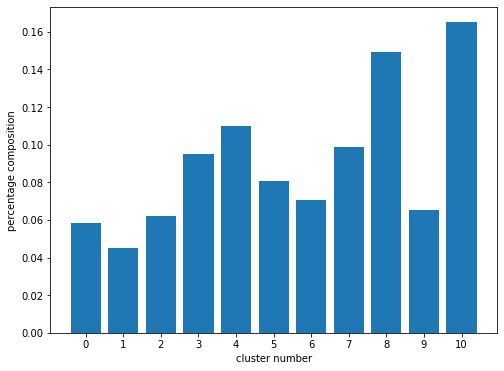

In [6]:
# counting the total number of buildings per GMM cluster in Manhattan
total_count = []
total_buildings = len(clusters)
for i in range(len(clusters.gmm.unique())):
    total_count.append(len(clusters[clusters.gmm==i])/total_buildings)

plt.figure(figsize=(8,6))
plt.bar(np.arange(11),total_count)
plt.xticks(np.arange(11))
plt.xlabel('cluster number')
plt.ylabel('percentage composition')
# plt.title('percentage composition of Manhattan by urban typology')
plt.show()

## Calculating neighborhood profile deviation from the Manhattan baseline

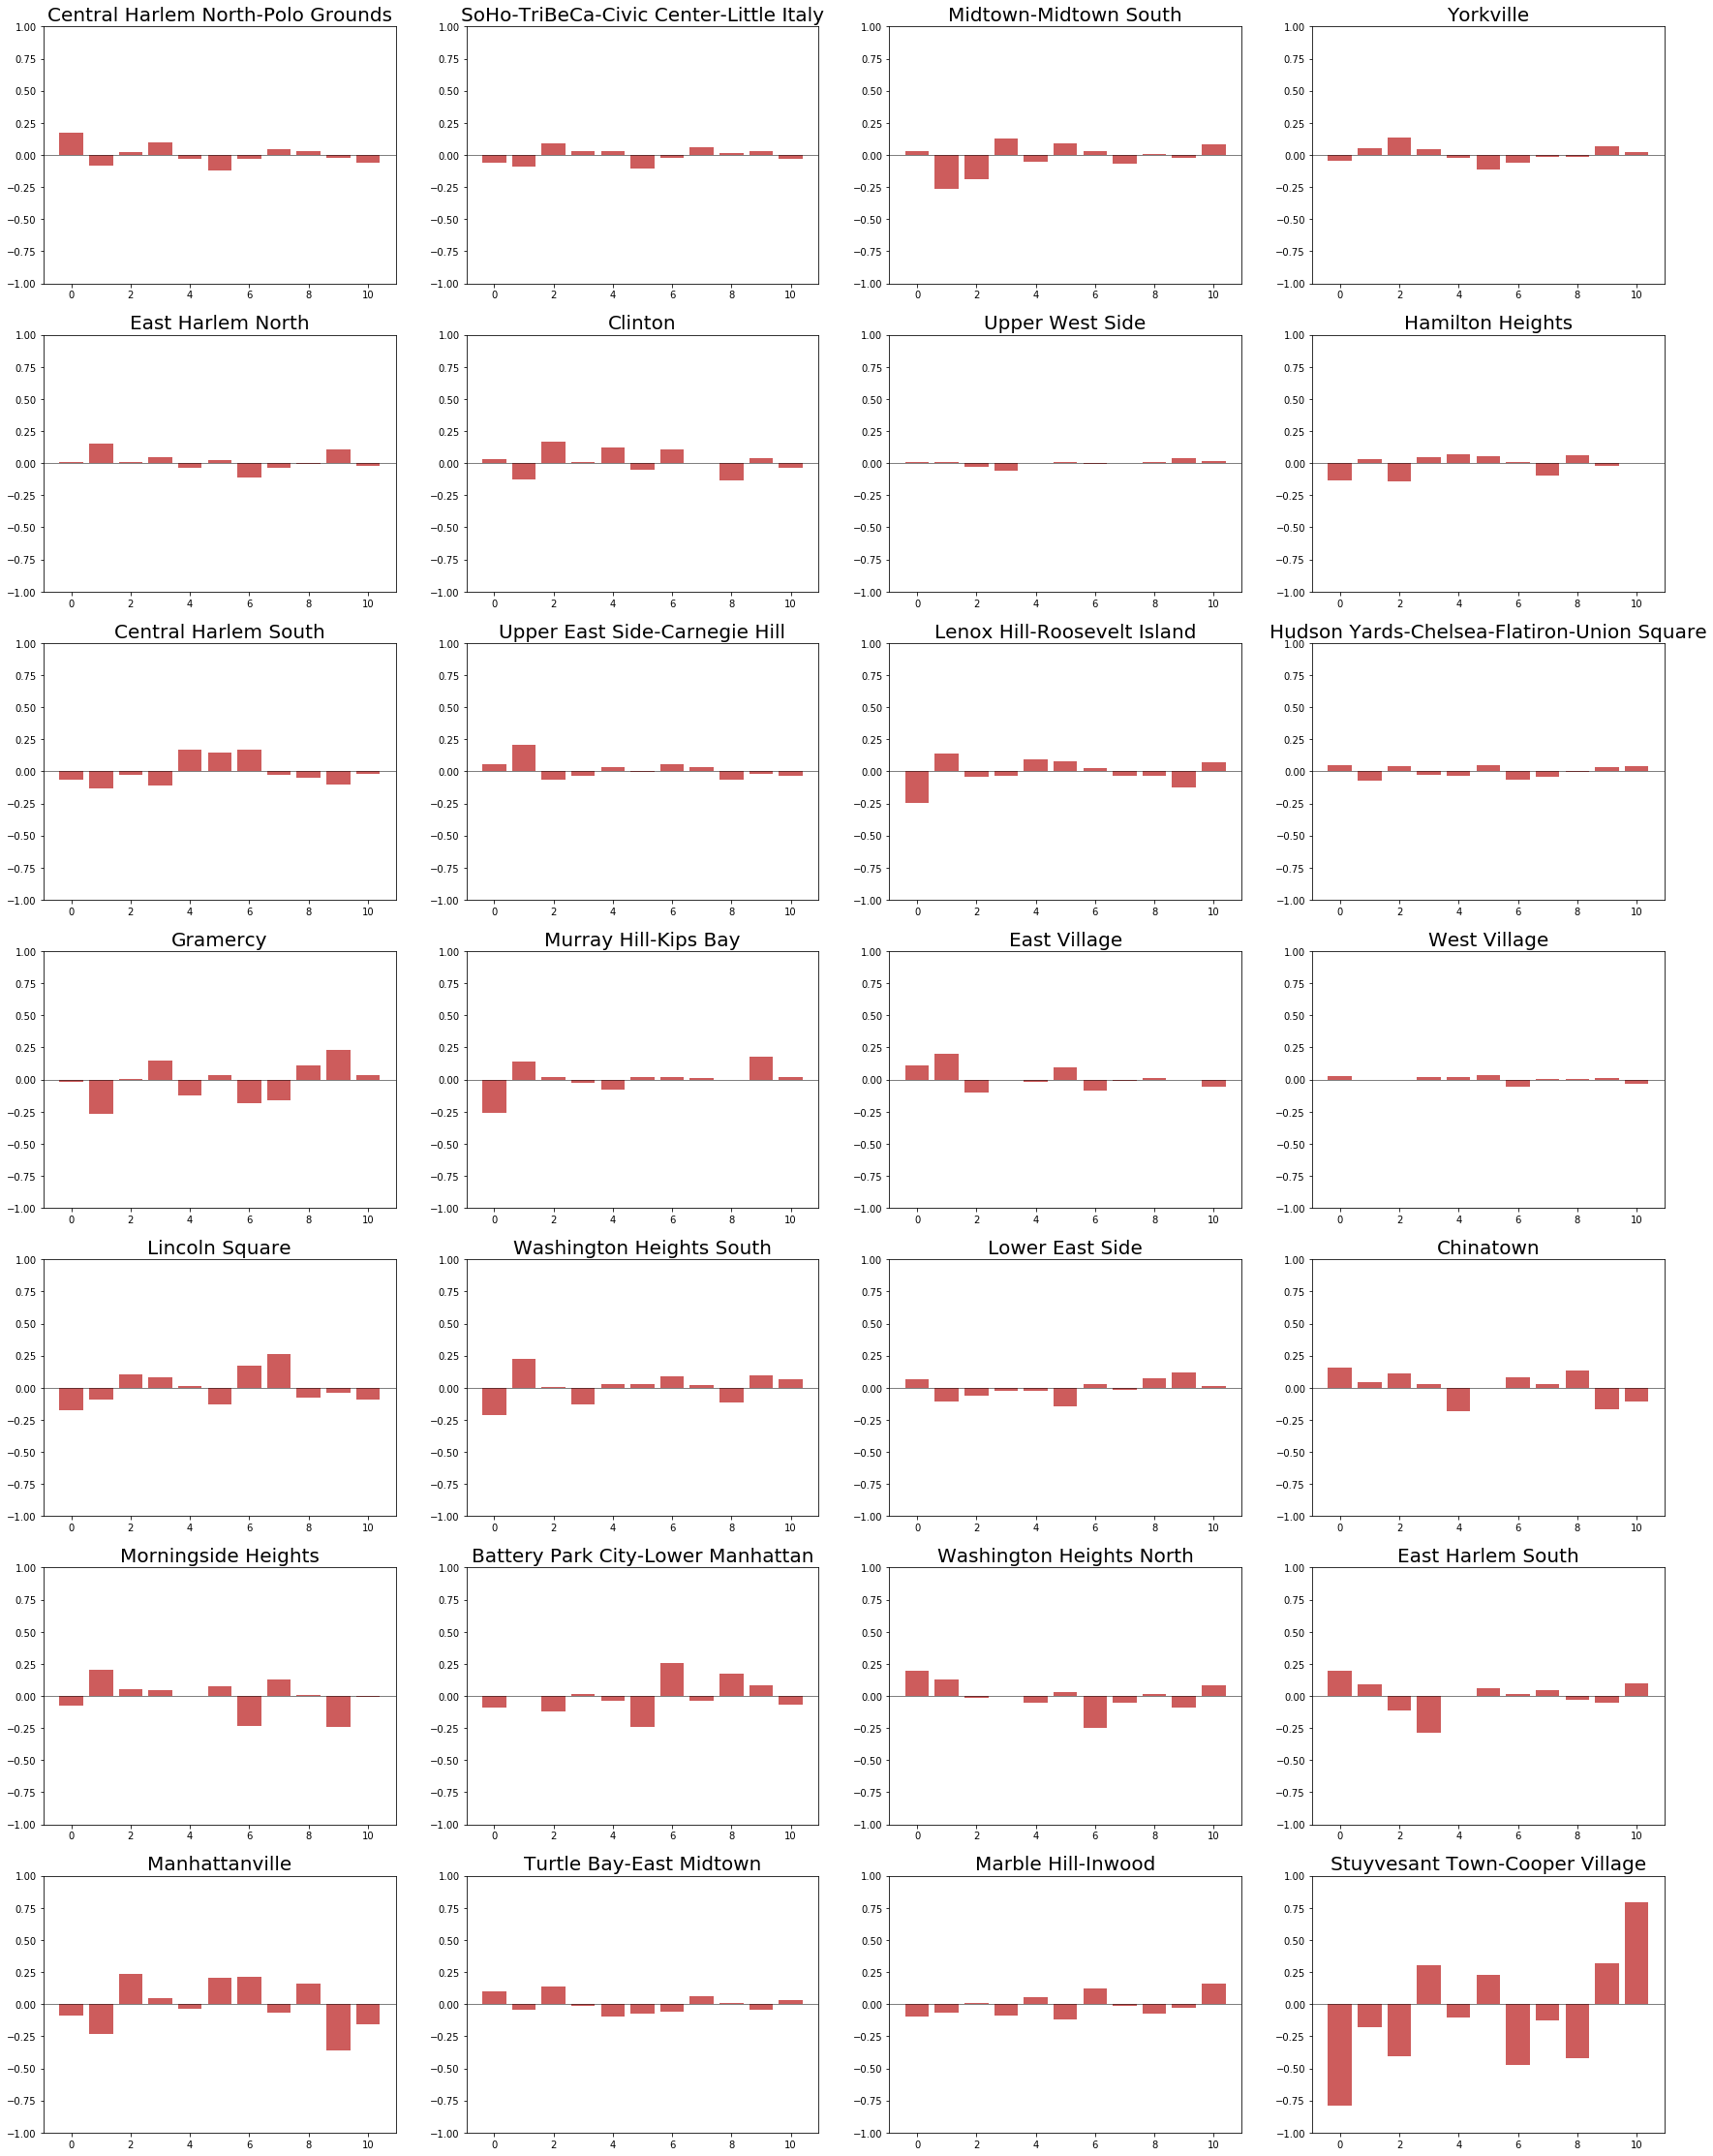

In [7]:
# groupby GMM cluster count by Neighborhood Tabulation Areas (NTA)
nta_names = clusters[clusters.nta!='park-cemetery-etc-Manhattan'].nta.unique()
fig, axs = plt.subplots(7,4,figsize=(30,40))
cols = [0,1,2,3]*7
rows = []
for i in range(7):
    rows += [i]*4
rows

# count the total number of buildings per NTA
total_count = []
total_buildings = len(clusters)
for i in range(len(clusters.gmm.unique())):
    total_count.append(len(clusters[clusters.gmm==i])/total_buildings)
    
# plot the deviation of each neighborhood profile from the Manhattan baseline
deviation_scores = []
for nta in range(28):
    gmm_count = []
    nta_profile = clusters[clusters.nta==nta_names[nta]]
    total_buildings = len(nta_profile)
    for i in range(len(clusters.gmm.unique())):
        gmm_count.append((len(nta_profile[nta_profile.gmm==i])/total_buildings)/total_count[i])
#     gmm_count = [(g-np.min(gmm_count))/(np.max(gmm_count)-np.min(gmm_count)) for g in gmm_count]
    axs[rows[nta],cols[nta]].bar(np.arange(len(clusters.gmm.unique())),[g-1 for g in gmm_count],color='indianred')
    axs[rows[nta],cols[nta]].axhline(y=0,color='black',lw=0.5)
    axs[rows[nta],cols[nta]].set_title(nta_names[nta],fontsize=20)
    axs[rows[nta],cols[nta]].set_ylim(-1,1)
    deviation = [(gmm_count[i]-total_count[i])**2 for i in range(len(clusters.gmm.unique()))]
    deviation_scores.append(np.sum(deviation))

In [9]:
# calculating the normalized deviation scores for each NTA
dev_nta = {}
deviation_norm = deviation_scores/np.linalg.norm(deviation_scores)
for i in range(28):
    dev_nta[nta_names[i]] = deviation_norm[i]
    
dev_nta

{'Central Harlem North-Polo Grounds': 0.18904995811609218,
 'SoHo-TriBeCa-Civic Center-Little Italy': 0.18572694227566033,
 'Midtown-Midtown South': 0.18024742526773363,
 'Yorkville': 0.18929135360139757,
 'East Harlem North': 0.19292933825211786,
 'Clinton': 0.19352382914928942,
 'Upper West Side': 0.18649364961919562,
 'Hamilton Heights': 0.18296410295768317,
 'Central Harlem South': 0.18718951332937483,
 'Upper East Side-Carnegie Hill': 0.19495605797832805,
 'Lenox Hill-Roosevelt Island': 0.18484094926069009,
 'Hudson Yards-Chelsea-Flatiron-Union Square': 0.18614154449025555,
 'Gramercy': 0.18416774835387642,
 'Murray Hill-Kips Bay': 0.19088481296749138,
 'East Village': 0.19403933697170347,
 'West Village': 0.18767154636179514,
 'Lincoln Square': 0.19197109064835519,
 'Washington Heights South': 0.19408124777317307,
 'Lower East Side': 0.18462986477590268,
 'Chinatown': 0.19449889068612725,
 'Morningside Heights': 0.188991105213005,
 'Battery Park City-Lower Manhattan': 0.187865114

In [12]:
# profiling zipcodes by GMM cluster distribution
zipcodes = clusters.zipcode.unique()
gmm_profile = {}
for zipcode in zipcodes:
    gmm_counts = []
    total_buildings = len(clusters[clusters.zipcode==zipcode])
    for i in range(5):
        gmm_counts.append(len(clusters[(clusters.zipcode==zipcode)&(clusters.gmm==i)])/total_buildings)
    gmm_profile[zipcode] = gmm_counts
    
gmm_profile_clusters = pd.DataFrame(gmm_profile).transpose()
#gmm_profile_clusters.head()

<BarContainer object of 5 artists>
0.3567571502214678
1.0000000000000002
50


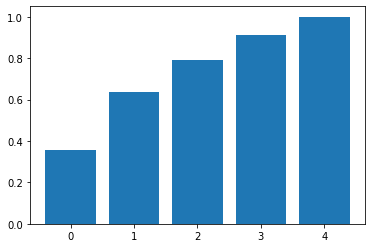

In [13]:
# PCA analysis on GMM cluster distribution by zipcode
pca = PCA(n_components=5)
gmm_pca = pca.fit_transform(gmm_profile_clusters.iloc[:,:11])
print(plt.bar(np.arange(5),pca.explained_variance_ratio_.cumsum()))
print(np.sum(pca.explained_variance_ratio_[:1]))
print(np.sum(pca.explained_variance_ratio_))
print(len(gmm_pca))

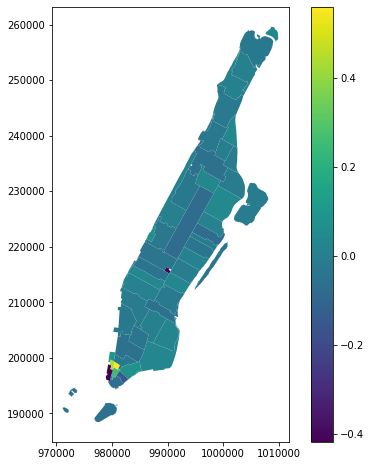

In [14]:
# plotting the top principal component by zipcode
manhattan_zip['gmm_pca'] = 0
zipcode_gmm_pca_values = [i[0] for i in gmm_pca]
norm_gmm_pca = zipcode_gmm_pca_values/np.linalg.norm(zipcode_gmm_pca_values)

for i in range(len(norm_gmm_pca)):
    try:
        zipcode = gmm_profile_clusters.index[i]
        #print(zipcode,i)
        manhattan_zip.loc[manhattan_zip.ZIPCODE==zipcode,'gmm_pca'] = norm_gmm_pca[i]
    except:
        continue

manhattan_zip.plot(figsize=(8,8), column='gmm_pca', legend=True)

In [15]:
# profiling NTAs by GMM cluster distribution
nta = clusters.nta.unique()
gmm_profile_nta = {}
for n in nta:
    gmm_counts = []
    total_buildings = len(clusters[clusters.nta==n])
    for i in range(11):
        gmm_counts.append(len(clusters[(clusters.nta==n)&(clusters.gmm==i)])/total_buildings)
    gmm_profile_nta[n] = gmm_counts
    
gmm_profile_clusters_nta = pd.DataFrame(gmm_profile_nta).transpose()
#gmm_profile_clusters_nta.head()

<BarContainer object of 5 artists>
0.9680684835052189
0.9934329163722802
30


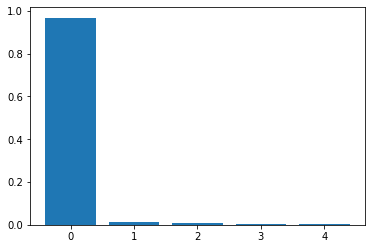

In [16]:
# PCA analysis on GMM cluster distribution by NTAs
pca = PCA(n_components=5)
gmm_nta_pca = pca.fit_transform(gmm_profile_clusters_nta.iloc[:,:11])
print(plt.bar(np.arange(5),pca.explained_variance_ratio_))
print(np.sum(pca.explained_variance_ratio_[:1]))
print(np.sum(pca.explained_variance_ratio_))
print(len(gmm_nta_pca))

(-0.08, 0.02)

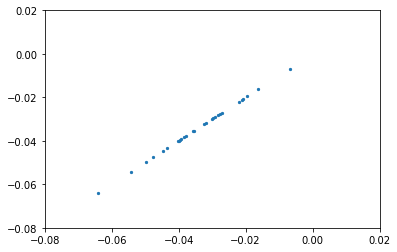

In [17]:
# plotting the top principal component
# top principal component explains a wide majority of total variance
df = pd.DataFrame(gmm_nta_pca)
plt.scatter(df.iloc[:,0],df.iloc[:,0],s=5)
plt.xlim(-0.08,0.02)
plt.ylim(-0.08,0.02)

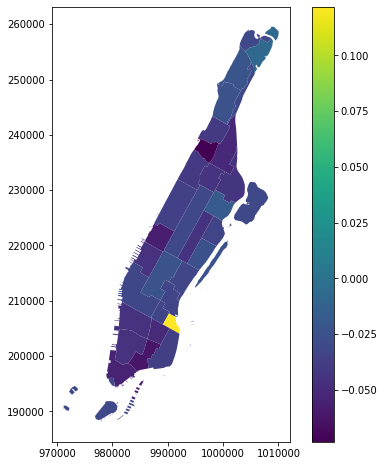

In [18]:
# plotting the top principal component by NTA
manhattan_nta['gmm_pca'] = 0
nta_pca_values = [i[0] for i in gmm_nta_pca]
norm_gmm_pca = nta_pca_values/np.linalg.norm(nta_pca_values)

for i in range(len(gmm_nta_pca)):
    try:
        ntacode = manhattan_nta[manhattan_nta.ntaname==gmm_profile_clusters_nta.index[i]].ntacode.values[0]
#         if gmm_profile_clusters_nta.index[i] != 'park-cemetery-etc-Manhattan':
        manhattan_nta.loc[manhattan_nta.ntacode==ntacode,'gmm_pca'] = norm_gmm_pca[i]
#         else:
#             manhattan_nta.loc[manhattan_nta.ntacode==ntacode,'gmm_pca'] = np.nan
    except:
        continue

manhattan_nta.plot(figsize=(8,8), column='gmm_pca', legend=True)

In [20]:
# urban layout typology descriptions for each GMM cluster
cluster_type = {0:['very sparse','mostly regular footprints','uneven grain'],
                1:['very dense','irregular footprints','very even grain'],
                2:['sparse','irregular footprints','uneven grain'],
                3:['dense','regular footprints','mostly even grain'],
                4:['moderate density','regular footprints','mostly even grain'],
                5:['moderate density','regular footprints','mostly even grain'],
                6:['very sparse','mostly regular footprints','very even grain'],
                7:['dense','regular footprints','uneven grain'],
                8:['moderate density','regular footprints','mostly even grain'],
                9:['sparse','irregular footprints','mostly even grain'],
                10:['moderate density','mostly regular footprints','very even grain']}

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


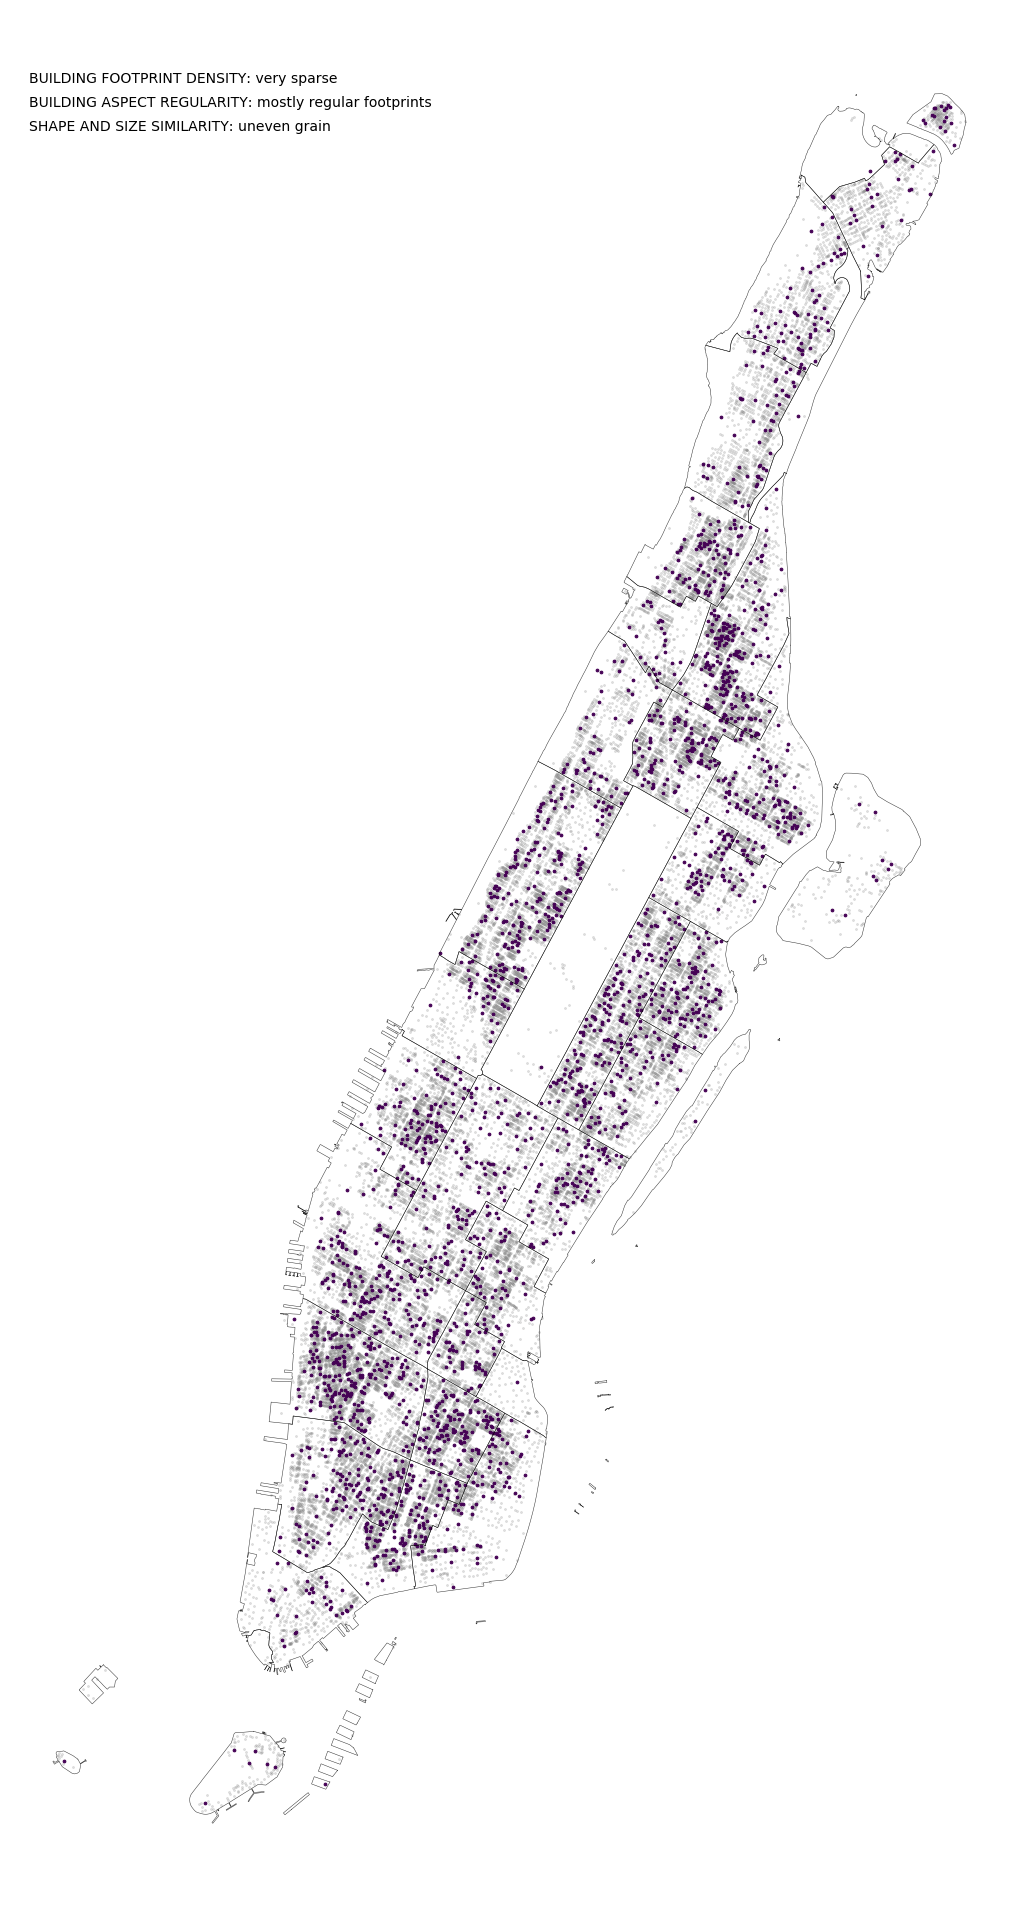

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


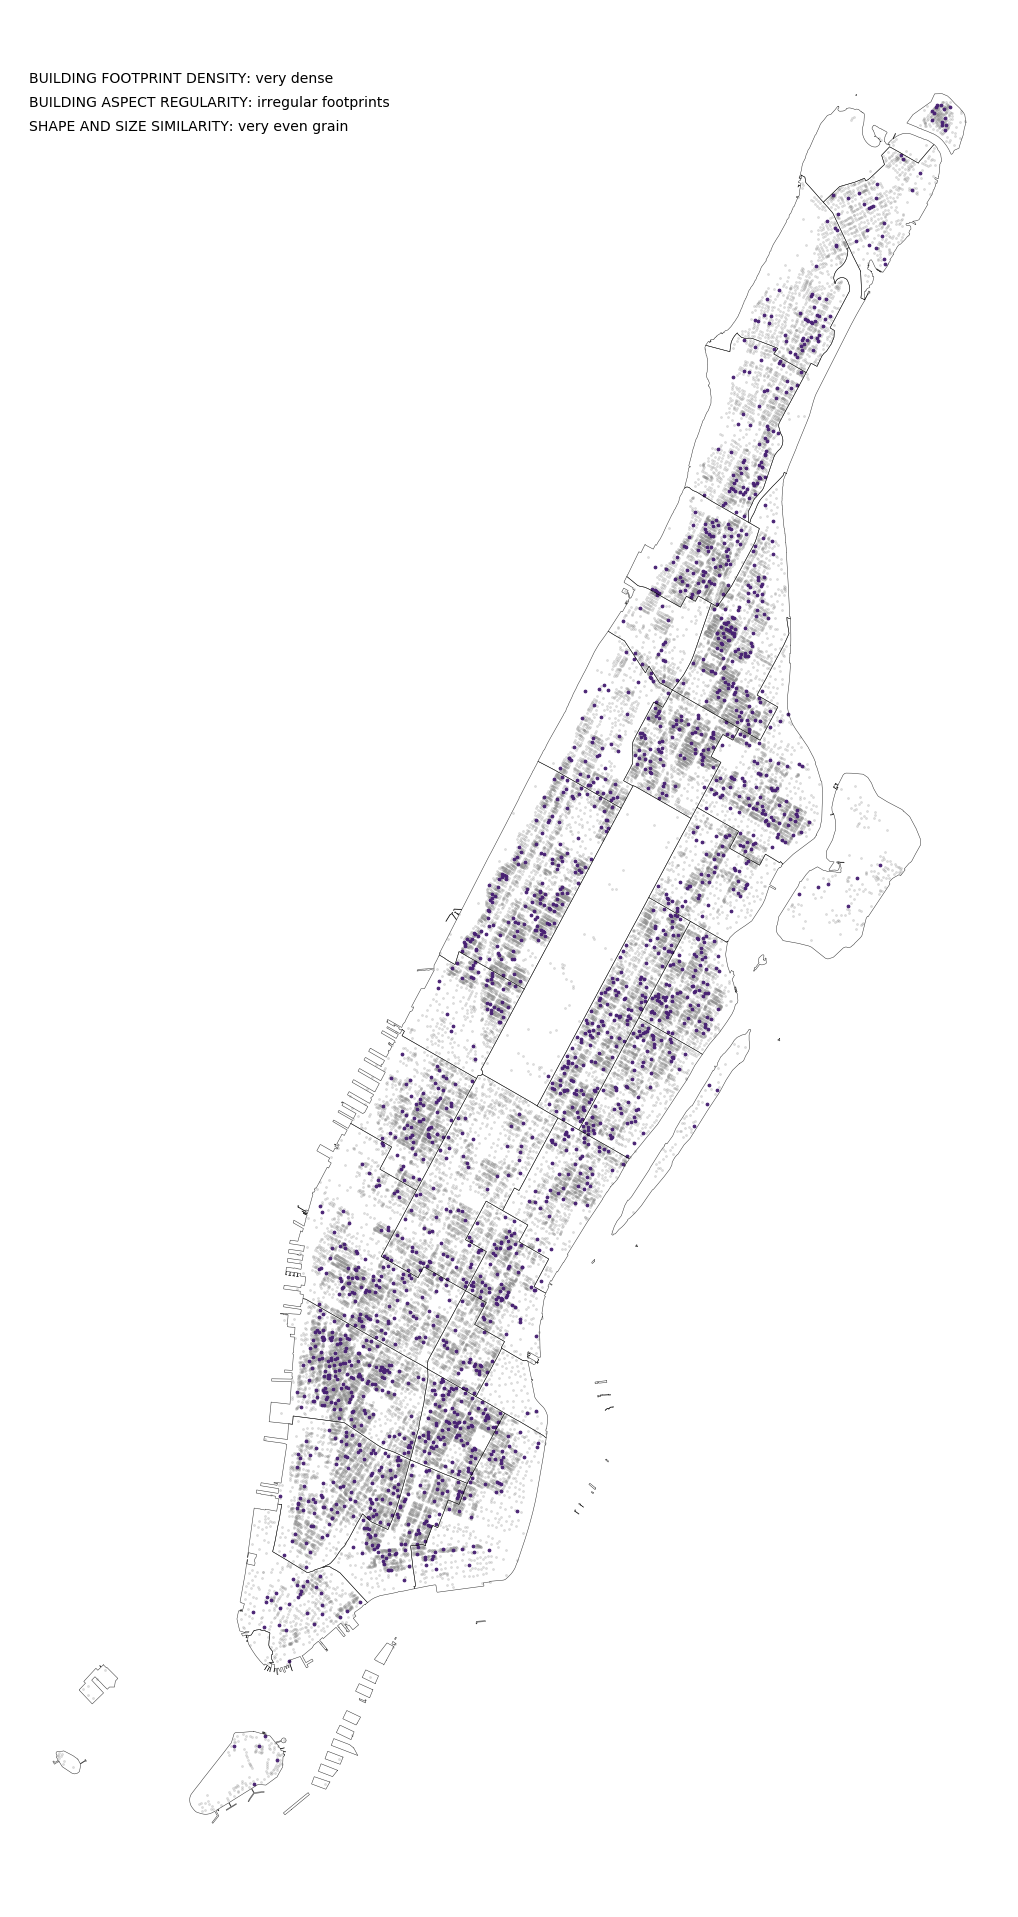

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


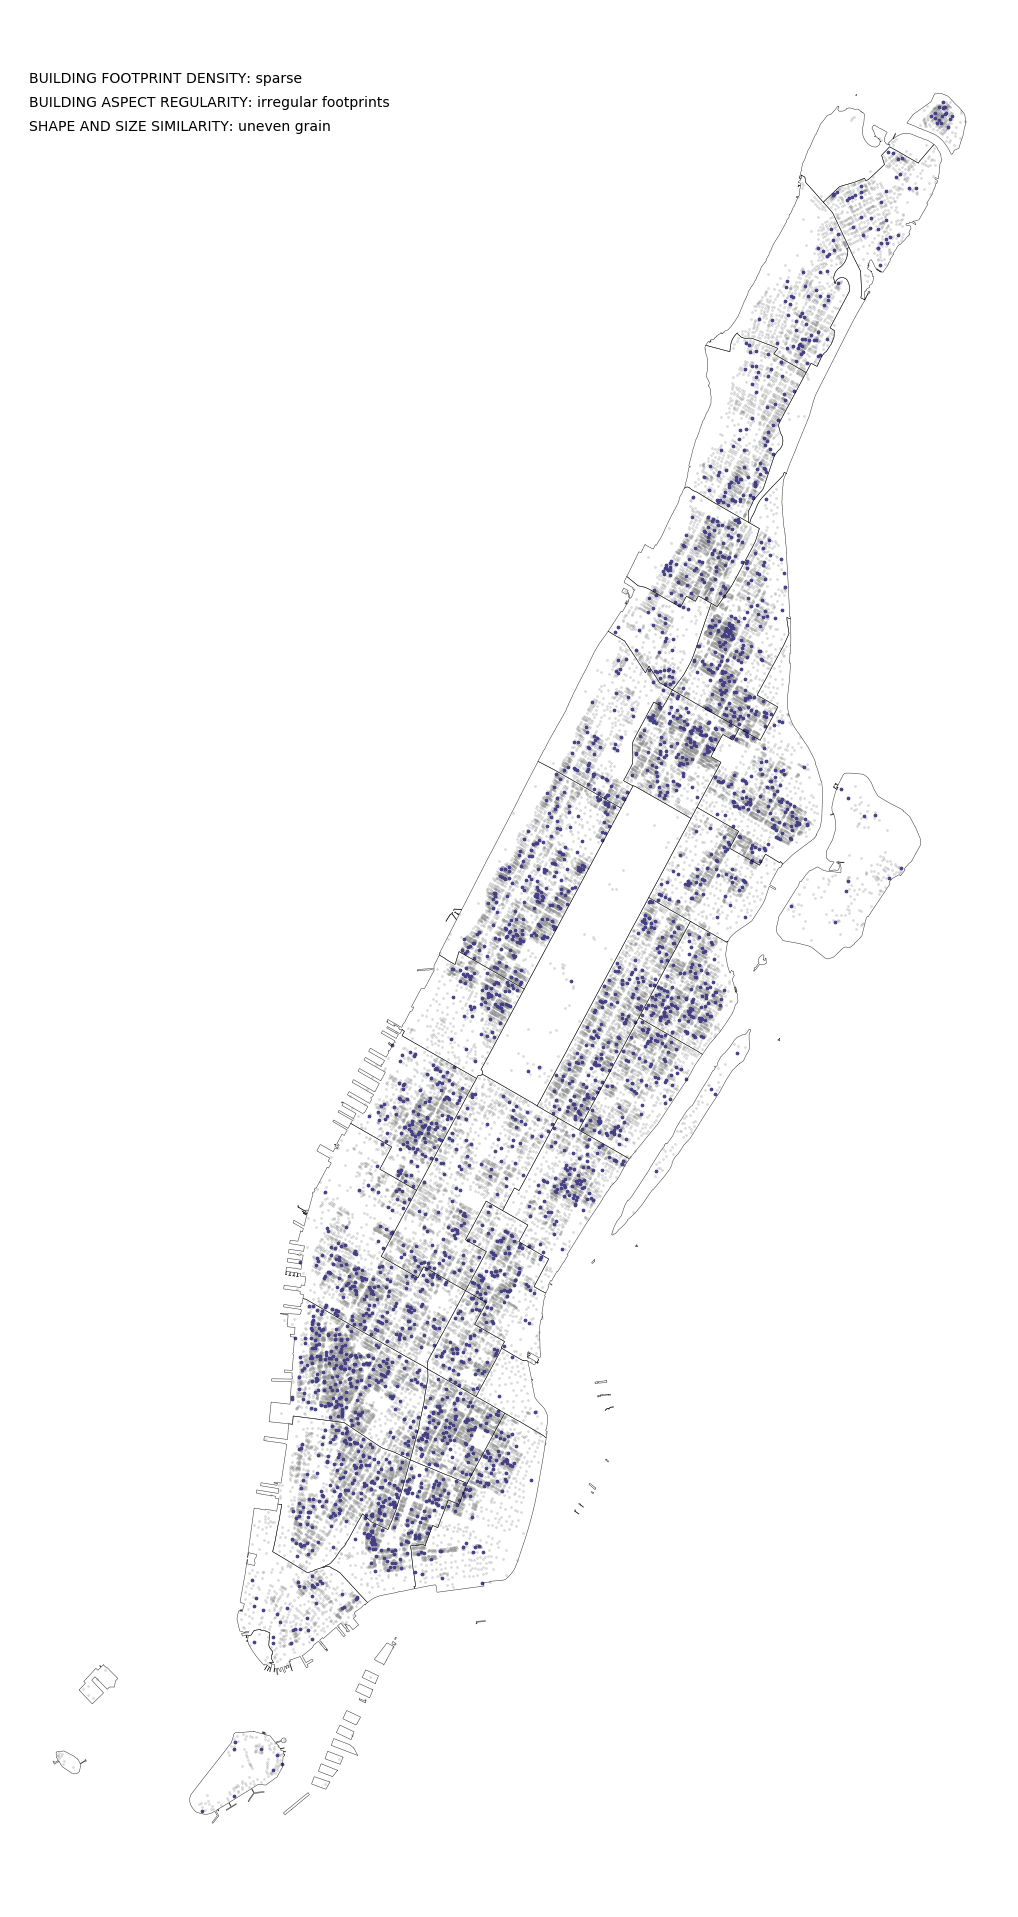

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


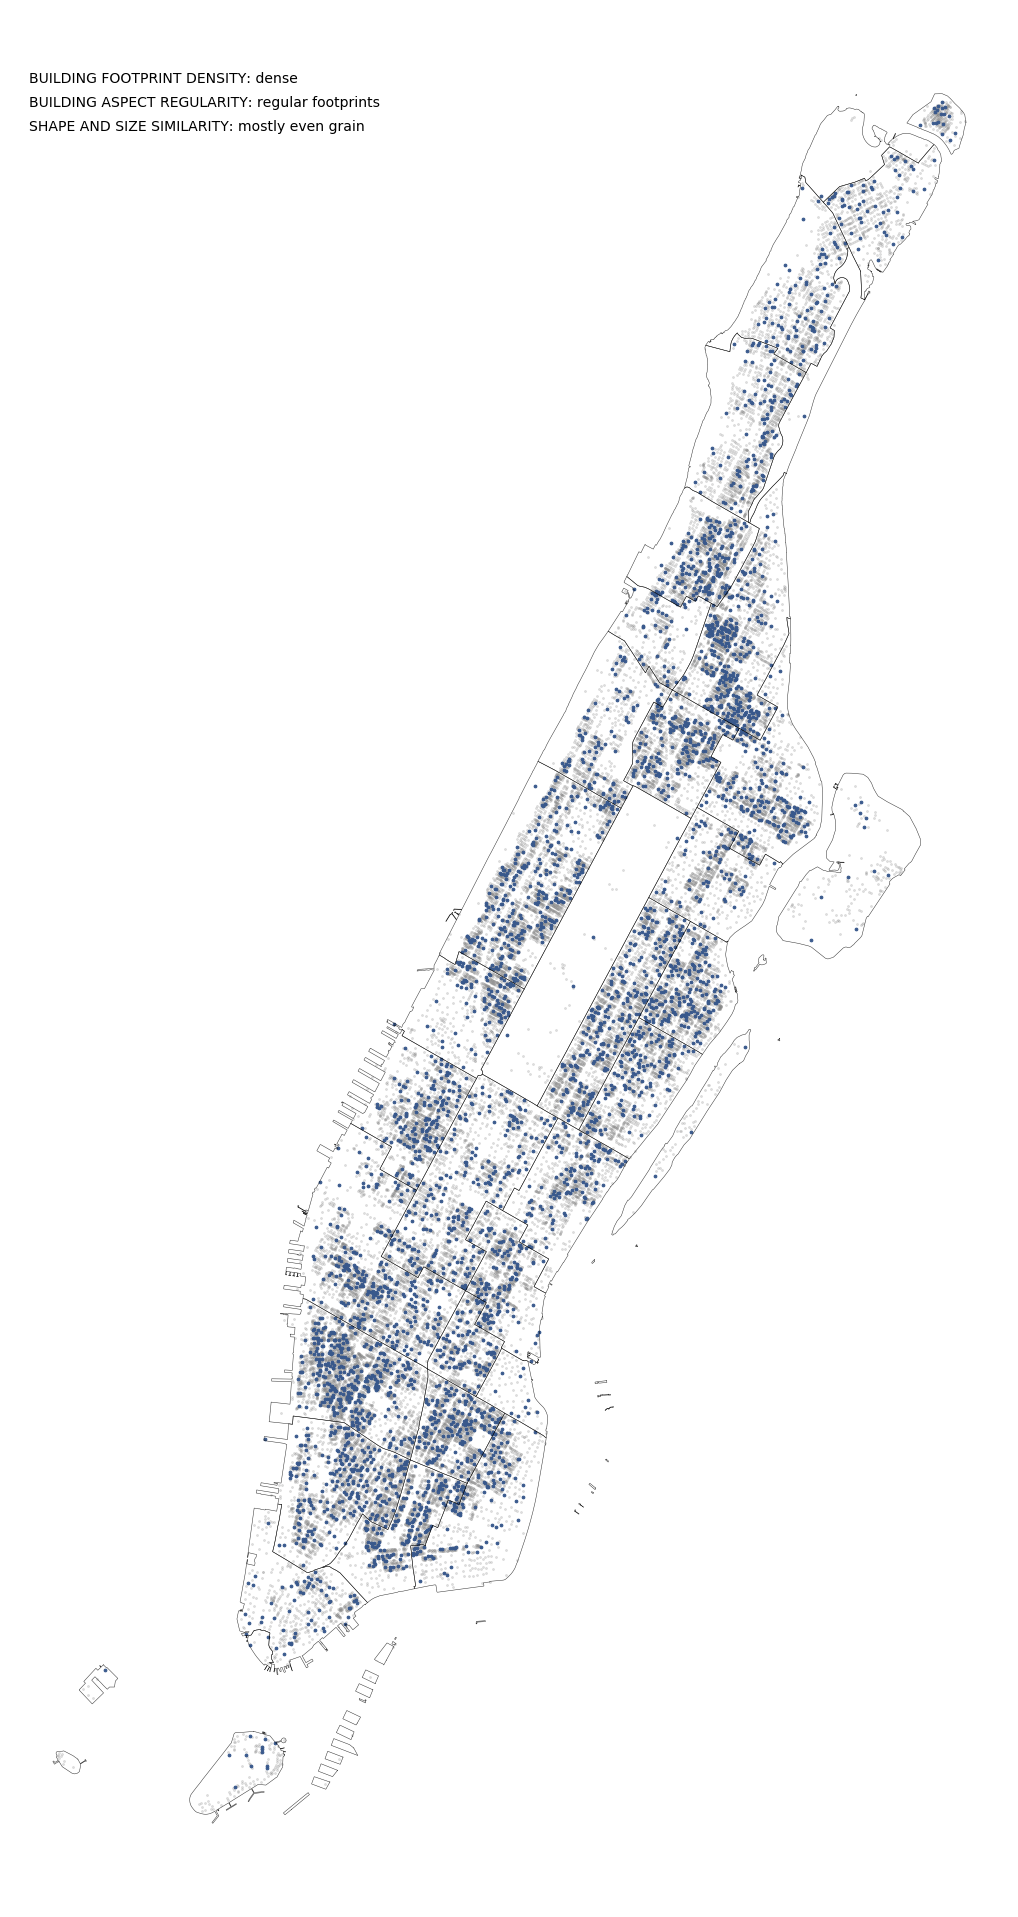

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


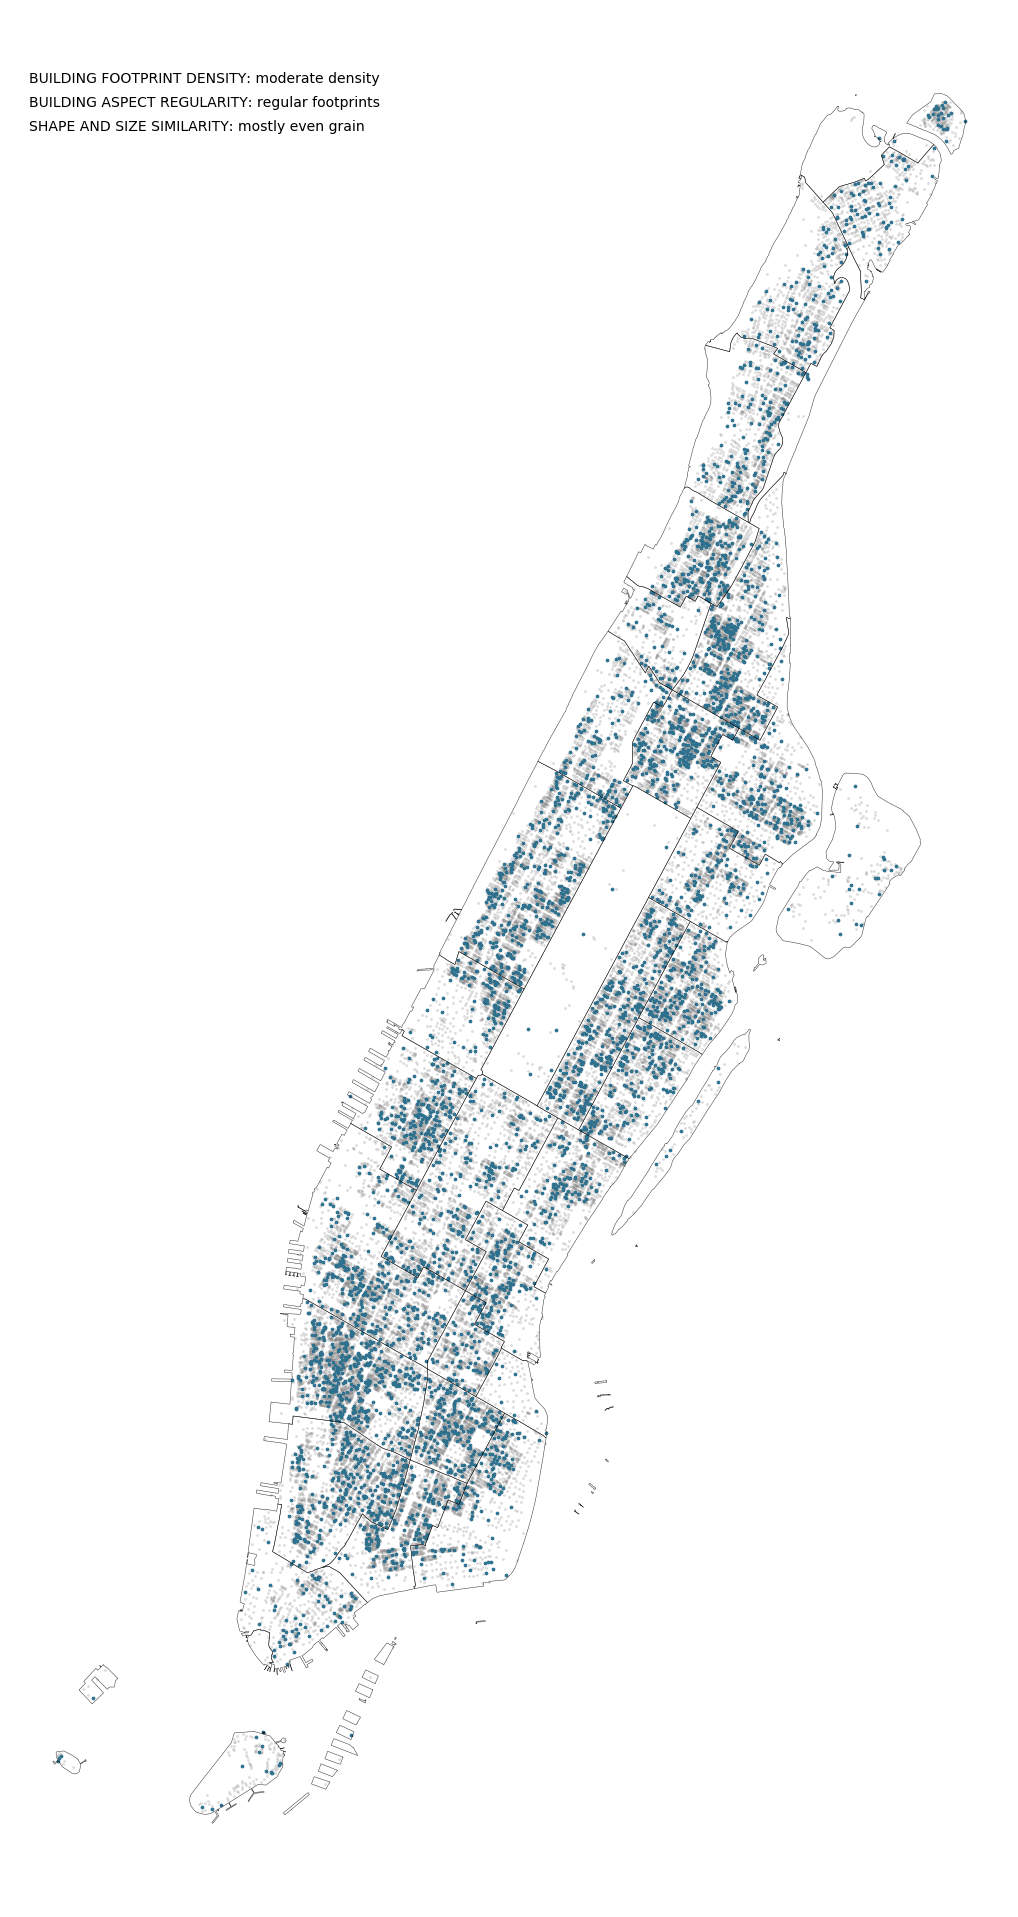

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


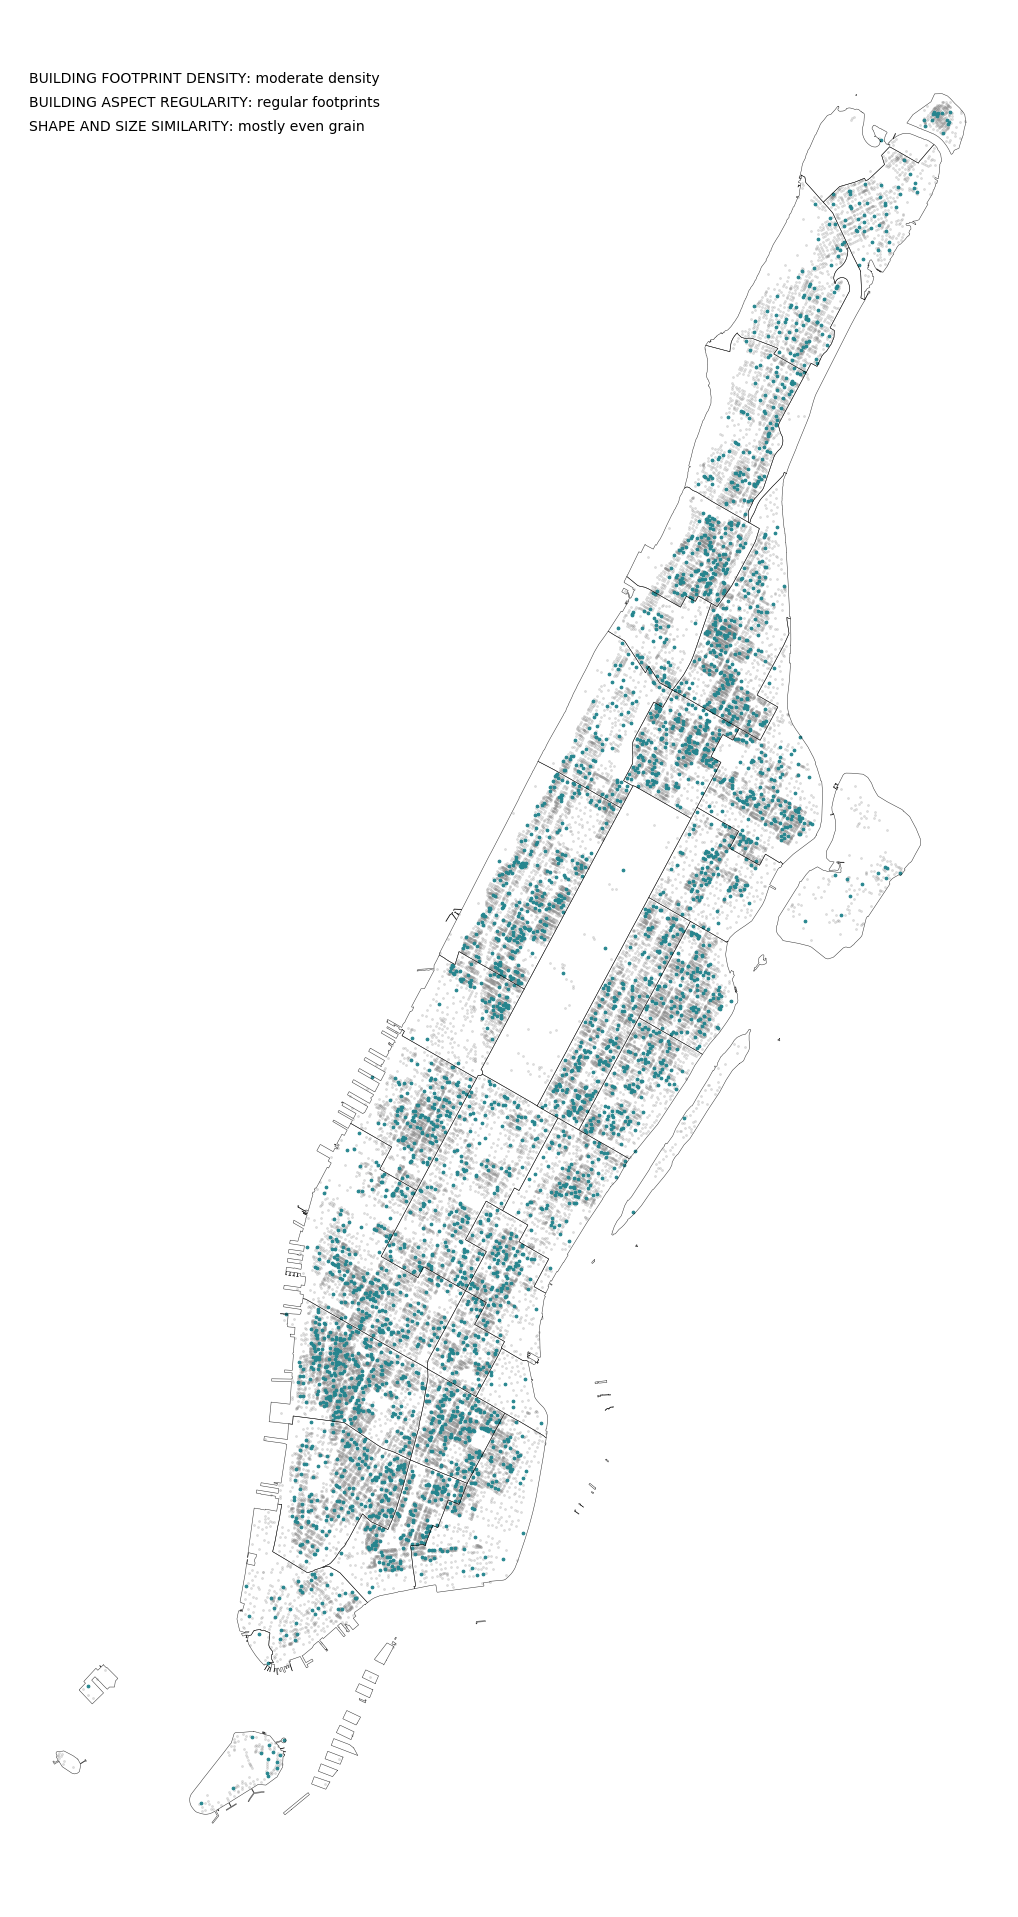

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


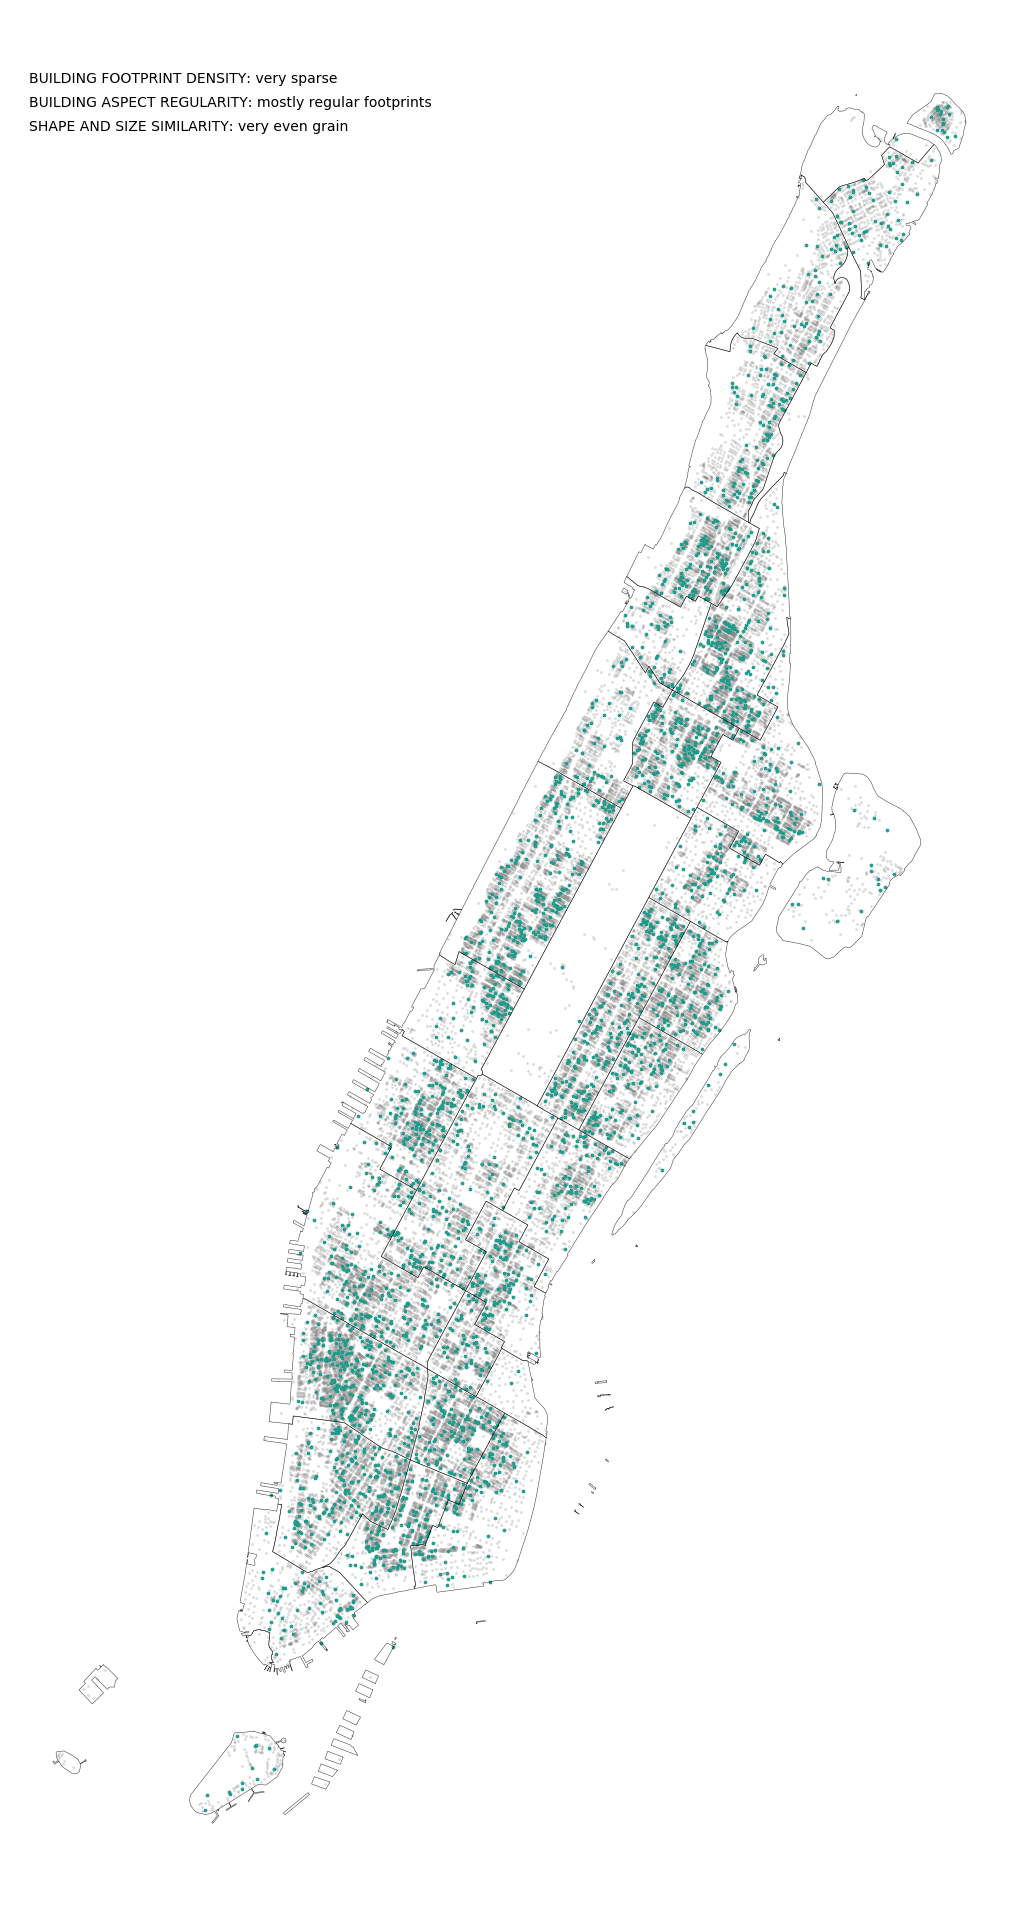

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


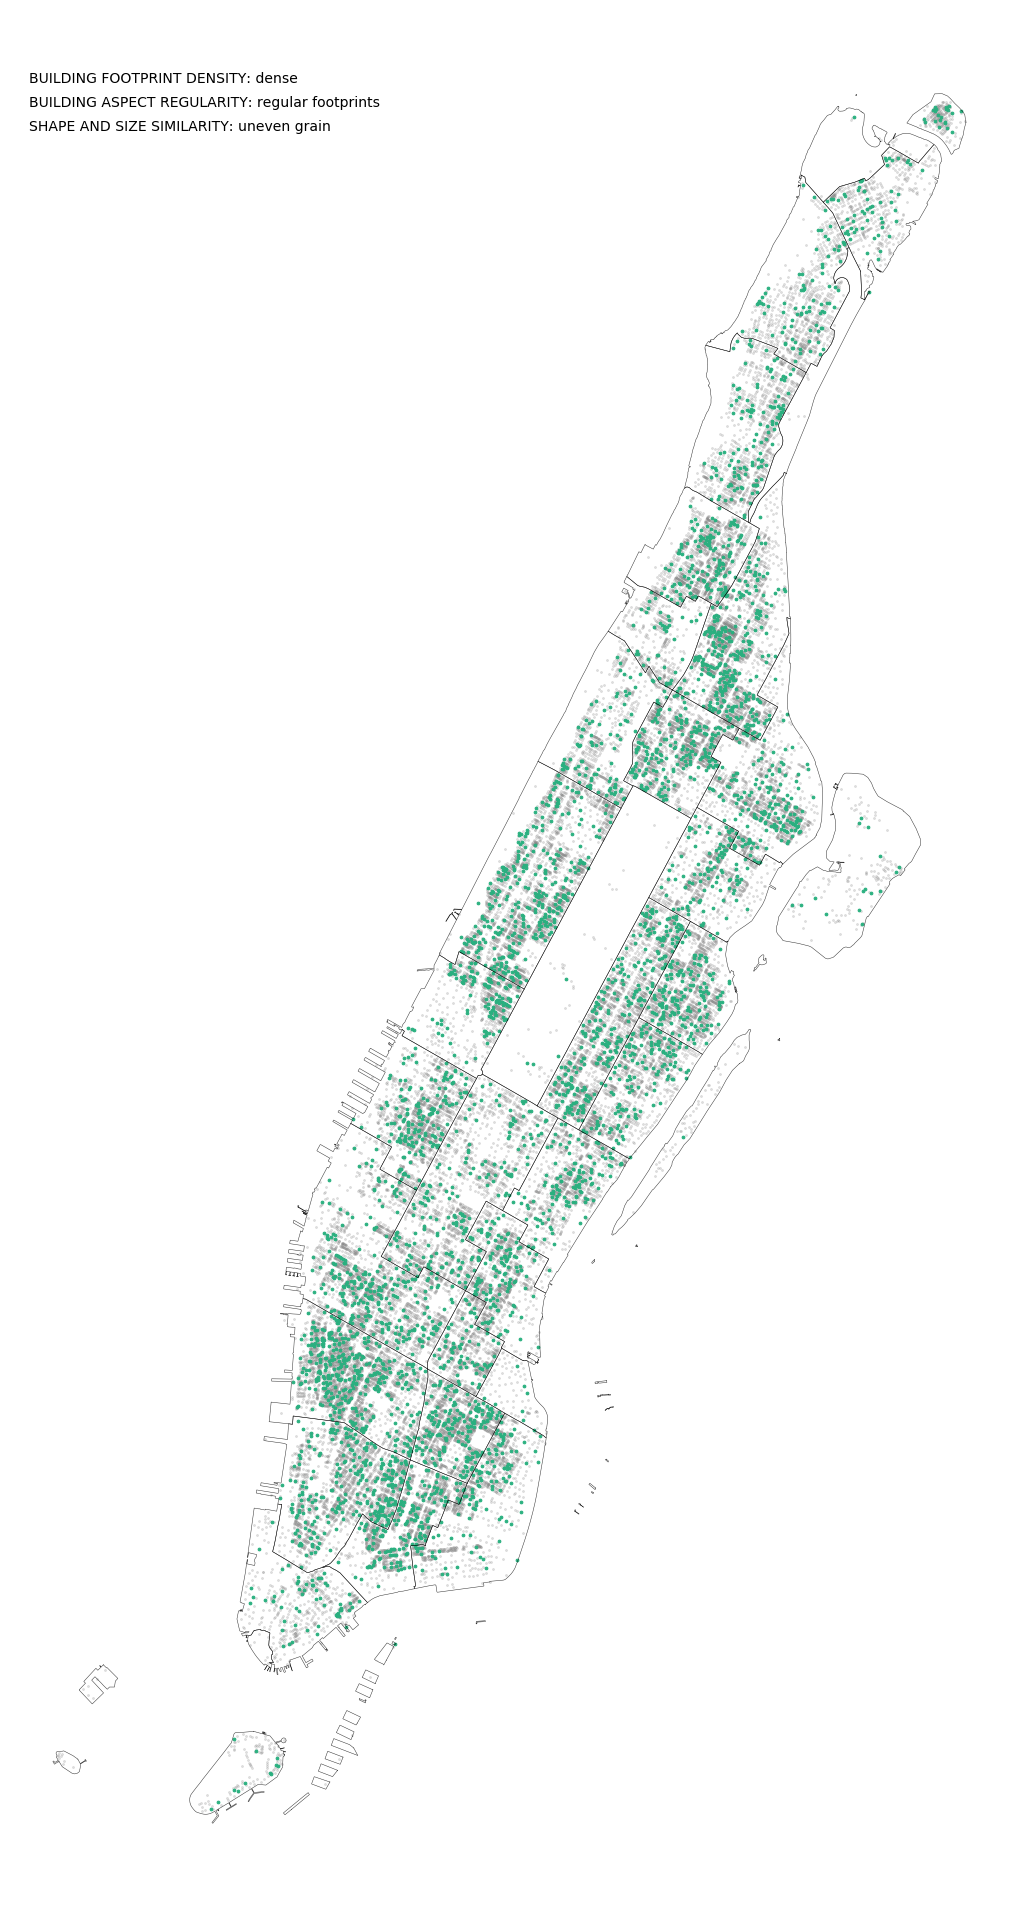

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


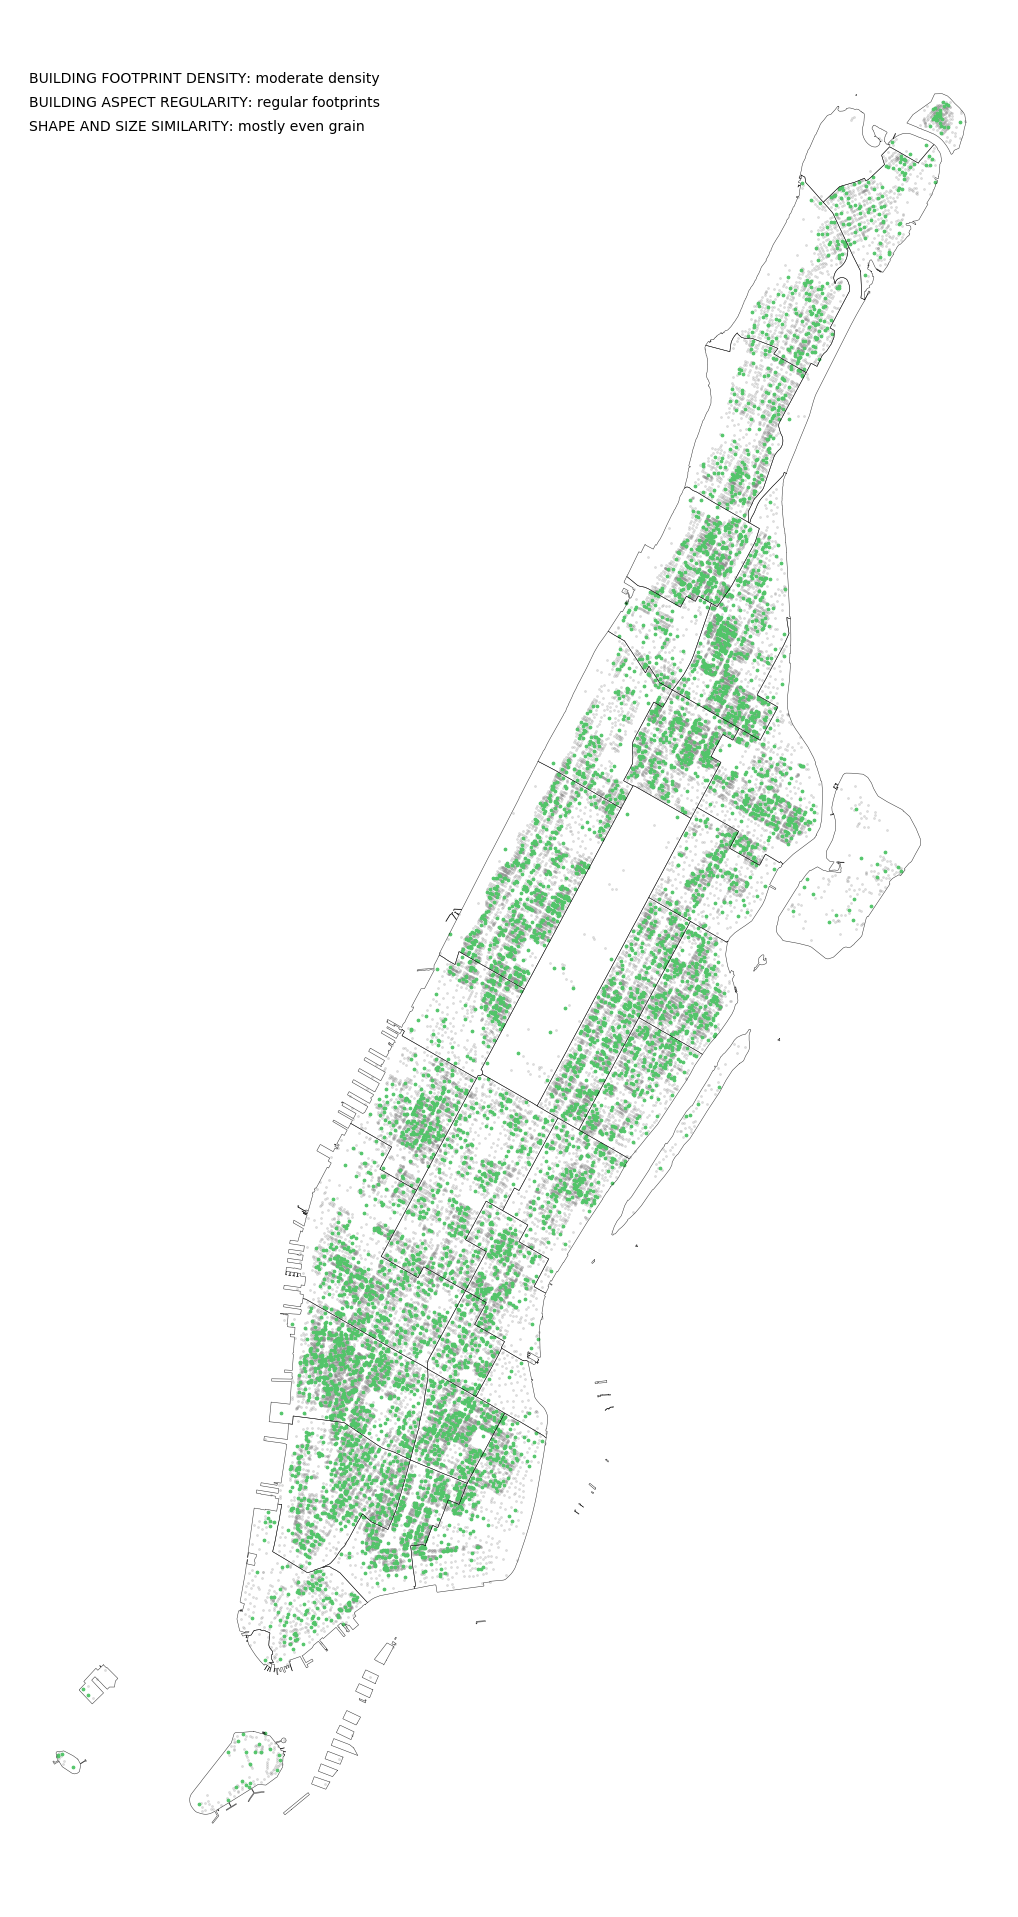

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


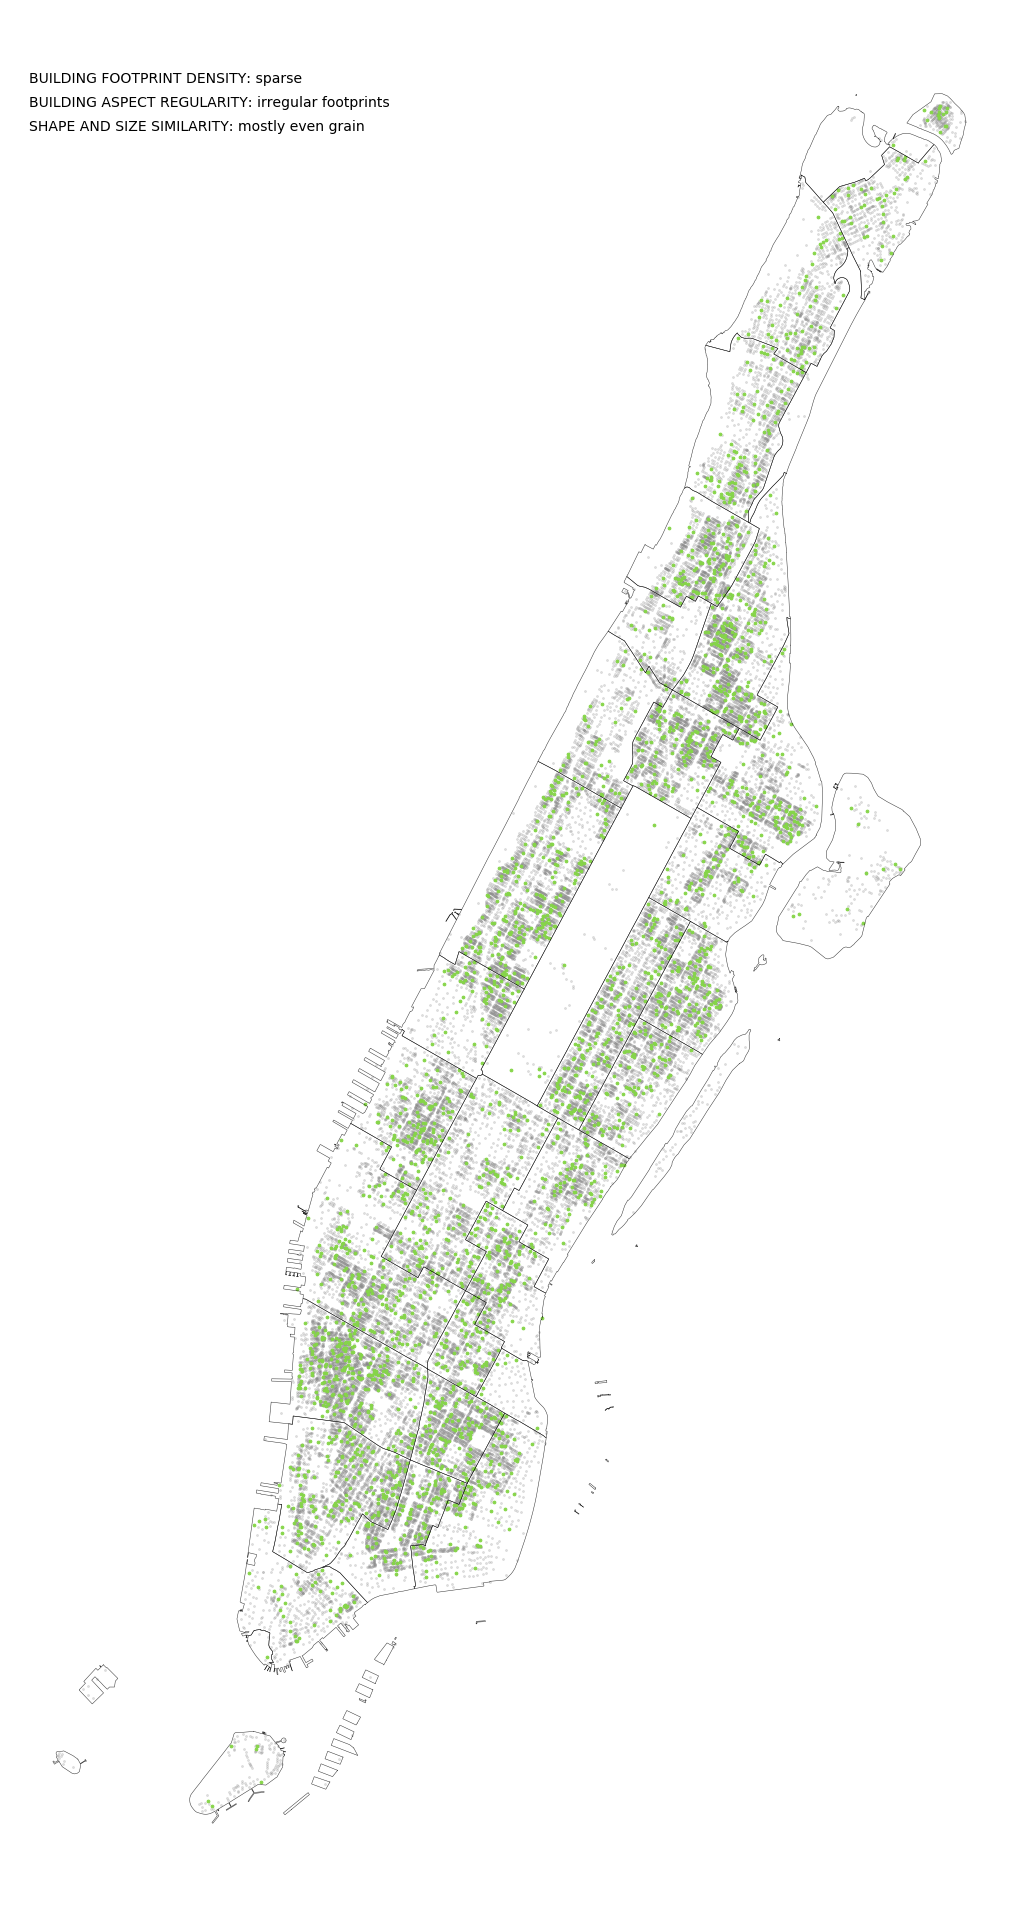

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


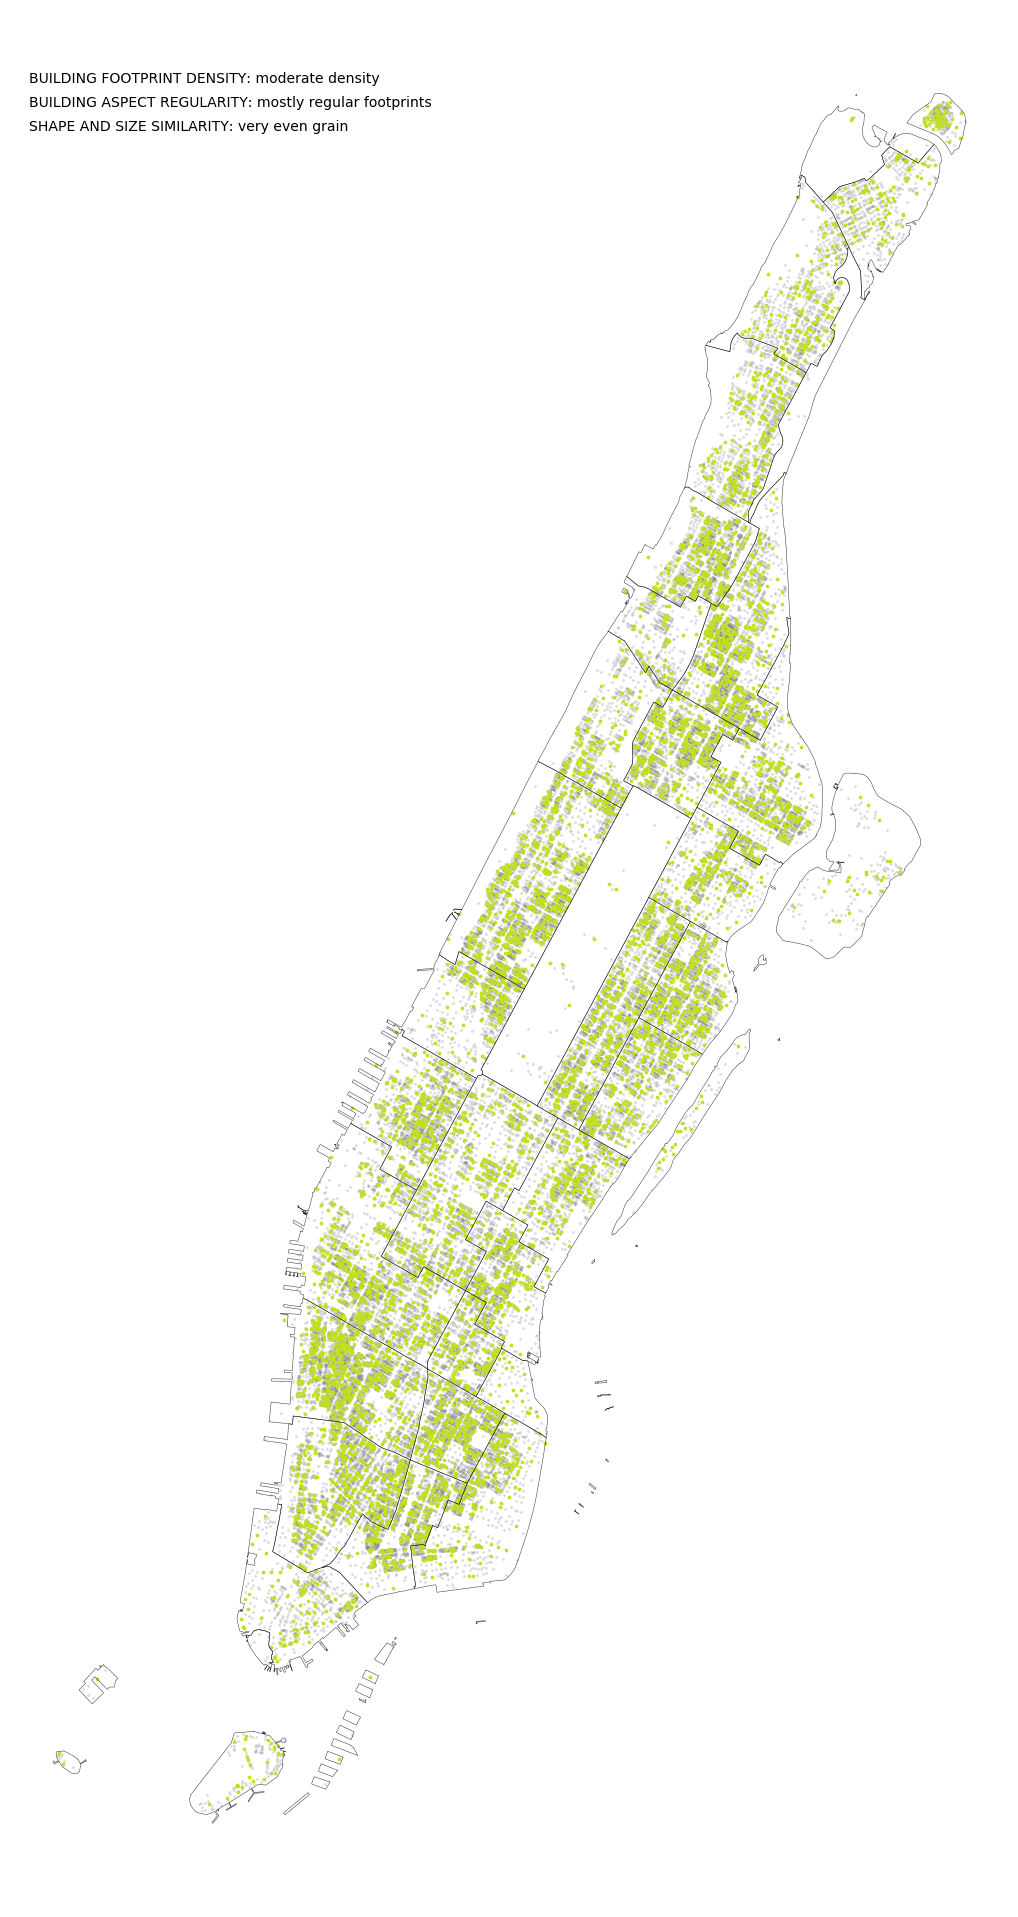

In [23]:
# plot the distribution of urban layout typologies on Manhattan
cmap = plt.get_cmap('viridis')
for t in range(11):
    plt.figure(figsize=(18,35))
    
    # plot NTA boundaries
    for i in range(len(manhattan_nta)):
        if manhattan_nta.iloc[i].geometry.type == 'Polygon':
            zx,zy = manhattan_nta.iloc[i].geometry.exterior.xy
            plt.plot(zx,zy,alpha=0.8,label=i,color='black',lw=0.5)
        else:
            coords = [list(x.exterior.xy) for x in manhattan_nta.iloc[i].geometry.geoms]
            for line in coords:
                zx,zy = line
                plt.plot(zx,zy,alpha=0.8,label=i,color='black',lw=0.5)

    # text description of each urban layout typology 
    plt.text(970000,260000,'BUILDING FOOTPRINT DENSITY: '+str(cluster_type[t][0]),fontsize=14)
    plt.text(970000,259000,'BUILDING ASPECT REGULARITY: '+str(cluster_type[t][1]),fontsize=14)
    plt.text(970000,258000,'SHAPE AND SIZE SIMILARITY: '+str(cluster_type[t][2]),fontsize=14)
    
    # plot the scatter points for each urban layout typology
    plt.scatter(clusters[clusters.gmm!=t].x,clusters[clusters.gmm!=t].y,marker='.',c='grey',alpha=0.2,s=15)
    plt.scatter(clusters[clusters.gmm==t].x,clusters[clusters.gmm==t].y,marker='.',c=cmap(1.*t/11),s=30)
    plt.axis('off')
    plt.show()